In [1]:
# Necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay


df = pd.read_csv('data/bank-additional.csv', sep=';')
print(df.head())

<ipython-input-1-9a767ba3e0c7>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


   age          job  marital          education default  housing     loan  \
0   30  blue-collar  married           basic.9y      no      yes       no   
1   39     services   single        high.school      no       no       no   
2   25     services  married        high.school      no      yes       no   
3   38     services  married           basic.9y      no  unknown  unknown   
4   47       admin.  married  university.degree      no      yes       no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0   cellular   may         fri  ...         2    999         0  nonexistent   
1  telephone   may         fri  ...         4    999         0  nonexistent   
2  telephone   jun         wed  ...         1    999         0  nonexistent   
3  telephone   jun         fri  ...         3    999         0  nonexistent   
4   cellular   nov         mon  ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.e

In [2]:
# Convert 'yes' to 1 and 'no' to 0 in the target variable
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Set 'y' as the target variable
y = df['y']

# Drop 'y' to create feature set X
X = df.drop('y', axis=1)

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Handle unknown categories in the test set
    ])

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Create a pipeline for preprocessing and modeling
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model.__class__.__name__}: {accuracy:.4f}")

# Instantiate the models
models = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    LogisticRegression(max_iter=1000),
    SVC()
]

# Evaluate each model
for model in models:
    evaluate_model(model, X_train, X_test, y_train, y_test)


Accuracy of KNeighborsClassifier: 0.8993
Accuracy of DecisionTreeClassifier: 0.8823
Accuracy of LogisticRegression: 0.9029
Accuracy of SVC: 0.9078


Tuning hyperparameters for knn...
Best parameters for KNeighborsClassifier: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Best cross-validated accuracy for KNeighborsClassifier: 0.9022
Accuracy on the full dataset (cross-validated): 0.9022


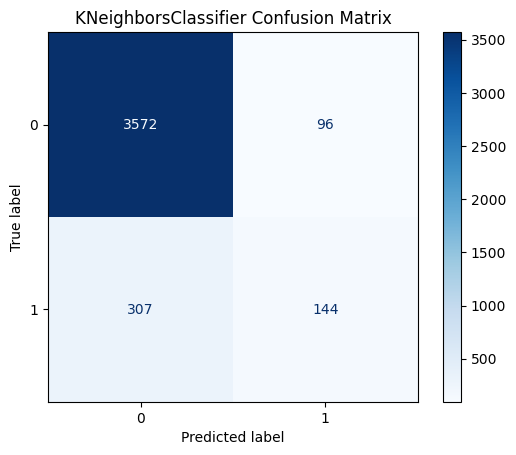

Tuning hyperparameters for decision_tree...
Best parameters for DecisionTreeClassifier: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
Best cross-validated accuracy for DecisionTreeClassifier: 0.9056
Accuracy on the full dataset (cross-validated): 0.9056


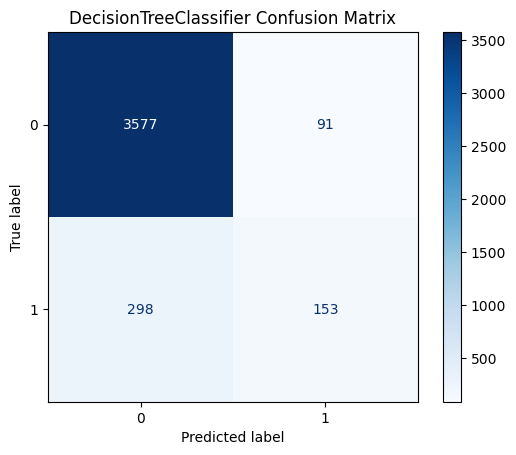

Tuning hyperparameters for logistic_regression...
Best parameters for LogisticRegression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validated accuracy for LogisticRegression: 0.9141
Accuracy on the full dataset (cross-validated): 0.9141


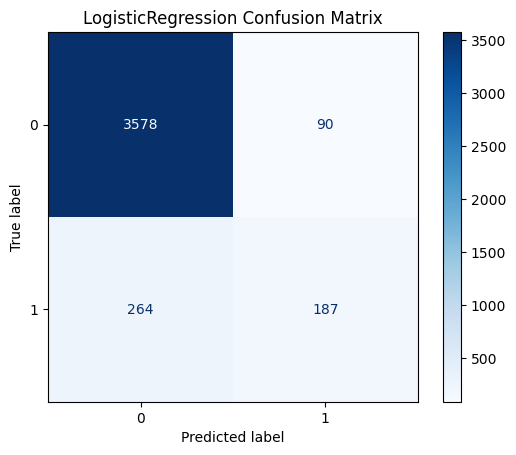

Tuning hyperparameters for svc...
Best parameters for SVC: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best cross-validated accuracy for SVC: 0.9104
Accuracy on the full dataset (cross-validated): 0.9104


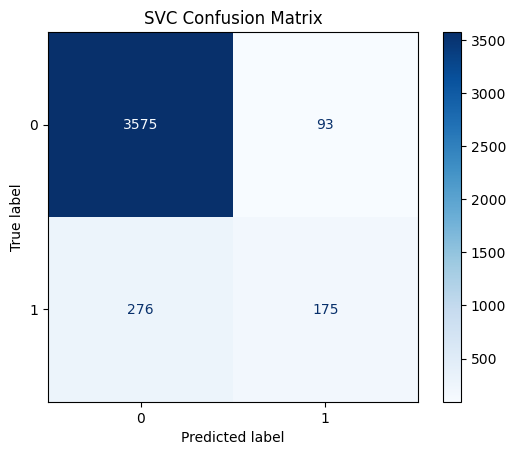

In [3]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Handle unknown categories in the test set
    ])

# Define the parameter grids for each model
param_grids = {
    'knn': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    'decision_tree': {
        'classifier__max_depth': [5, 10, None],
        'classifier__min_samples_split': [2, 10, 20]
    },
    'logistic_regression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']  # 'liblinear' supports l1 and l2 penalties
    },
    'svc': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }
}

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Function to perform grid search and cross-validated predictions
def grid_search_model(model, param_grid, X, y):
    # Create a pipeline for preprocessing and modeling
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    # Perform Grid Search with Cross Validation
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    
    # Best parameters and best score
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best cross-validated accuracy for {model.__class__.__name__}: {grid_search.best_score_:.4f}")
    
    # Generate cross-validated predictions
    y_pred = cross_val_predict(grid_search.best_estimator_, X, y, cv=5)
    
    # Evaluate accuracy on the full dataset
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy on the full dataset (cross-validated): {accuracy:.4f}")
    
    # Plot confusion matrix for each model
    plot_confusion_matrix(y, y_pred, f"{model.__class__.__name__} Confusion Matrix")

    return grid_search.best_estimator_

# Instantiate the models
models = [
    ('knn', KNeighborsClassifier()),
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('logistic_regression', LogisticRegression(max_iter=1000)),
    ('svc', SVC())
]

#dictionary to store the best models
best_models = {}

# Perform grid search and cross-validated evaluation for each model
for model_name, model in models:
    print(f"Tuning hyperparameters for {model_name}...")
    best_model = grid_search_model(model, param_grids[model_name], X, y)  # Assuming grid_search_model returns the best model
    best_models[model_name] = best_model  # Store the best model in the dictionary

              Feature  Importance  Absolute_Importance
1            duration    1.218907             1.218907
50          month_mar    0.744508             0.744508
51          month_may   -0.737323             0.737323
44  contact_telephone   -0.620937             0.620937
60   poutcome_failure   -0.585167             0.585167
34         default_no   -0.440277             0.440277
52          month_nov   -0.439384             0.439384
9         nr.employed   -0.423289             0.423289
5        emp.var.rate   -0.373484             0.373484
49          month_jun    0.358401             0.358401


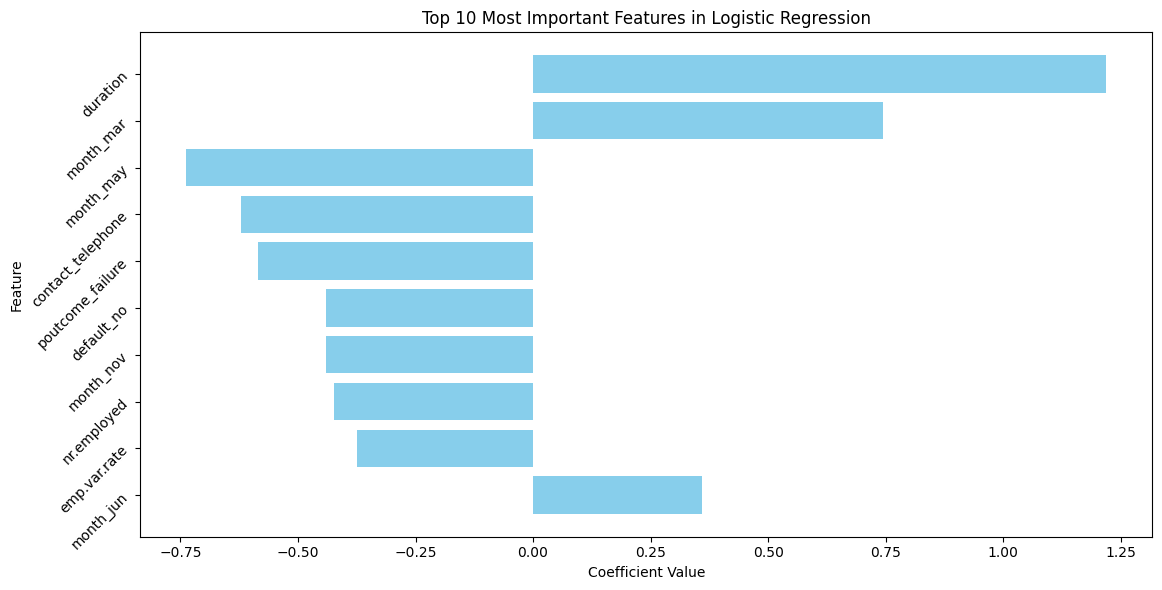

In [4]:
# Numerical features (they retain their names)
numerical_feature_names = numerical_features

# Get feature names from the OneHotEncoder (categorical features)
categorical_feature_names = best_models['logistic_regression'].named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)

# Combine numerical and categorical feature names
all_feature_names = np.hstack([numerical_feature_names, categorical_feature_names])

# Get the coefficients from the Logistic Regression model
coefficients = best_models['logistic_regression'].named_steps['classifier'].coef_[0]

# Create a DataFrame for better readability
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': coefficients
})

# Sort by absolute value of the importance
feature_importance['Absolute_Importance'] = np.abs(feature_importance['Importance'])
feature_importance = feature_importance.sort_values(by='Absolute_Importance', ascending=False)

# Select the top 10 most important features
top_10_features = feature_importance.head(10)

# Display the top 10 feature importance
print(top_10_features)

# Plot the top 10 feature importance
plt.figure(figsize=(12, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features in Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis so that the most important feature is at the top
plt.tight_layout()
plt.yticks(rotation=45)
plt.savefig('importance', bbox_inches='tight', pad_inches=0.2)
plt.show()
